In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
wine = datasets.load_wine()
#wine = wine['data']
feature_names = wine['feature_names']

data = pd.DataFrame(wine['data'], columns=feature_names)
target = wine.target


In [4]:
#get covariance matrix of dataset
covMatrix = data.cov()

In [6]:
print(np.mean(data['alcohol']))
print(np.std(data['alcohol']))


13.000617977528083
0.809542914528517


In [8]:
#Get normalized data
def normalize(data): 
    normData = data.copy()
    for col in normData.columns:
        #print(col, end=': ')
        mean = np.mean(normData[col])
        #print('mean', mean, end='; ')
        std = np.std(normData[col])
        #print('std', std)
        #print()
        #normData.index
        for row in normData.index:
            #print('x', normData.iloc[row])
            #print('mean', mean)
            #print('std', std)
            normData.loc[row, col] = (normData.loc[row, col] - mean) / std
            #print(normData.at[row, col])
    return normData

In [9]:
normData = normalize(data)

In [345]:
#get covariance of normalized data
normCovMatrix = normData.cov()

In [12]:
#Every pair of metrics shows up twice
#This function removes one version of each pair (along with pricipal axis in which all correlations equal 1.0)
def removeUpperTriangle(data):
    toRemove = set()
    cols = data.columns
    for i in range(len(data.columns)):
        for j in range(0, i+1):
            toRemove.add((cols[i], cols[j]))
    return toRemove

#return the highest correlations
def sortCovMatrix(data, n):
    corrs = data.corr().abs().unstack()
    dropLabels = removeUpperTriangle(data)
    corrs = corrs.drop(labels=dropLabels).sort_values(ascending=False)
    
    return corrs[0:n]


In [13]:
n = 4
sortedCovs = sortCovMatrix(normData, n)

In [16]:
sortCovMatrix(data, 4)

total_phenols  flavanoids                      0.864564
flavanoids     od280/od315_of_diluted_wines    0.787194
total_phenols  od280/od315_of_diluted_wines    0.699949
flavanoids     proanthocyanins                 0.652692
dtype: float64

In [17]:
#save the top features in a set
topCovs = set()
for i in sortedCovs.index:
    for j in range(2):
        topCovs.add(i[j])
topCovs = list(topCovs)

In [18]:
topCovs

['proanthocyanins',
 'flavanoids',
 'od280/od315_of_diluted_wines',
 'total_phenols']

In [19]:
newData = data[topCovs]
newData.shape

(178, 4)

In [343]:
#top features covariance matrix
newCov = newData.cov()

In [344]:
#top features normalized covariance matrix
normNewCov = normalize(newData).cov()

In [250]:
features

['proanthocyanins',
 'flavanoids',
 'od280/od315_of_diluted_wines',
 'total_phenols']

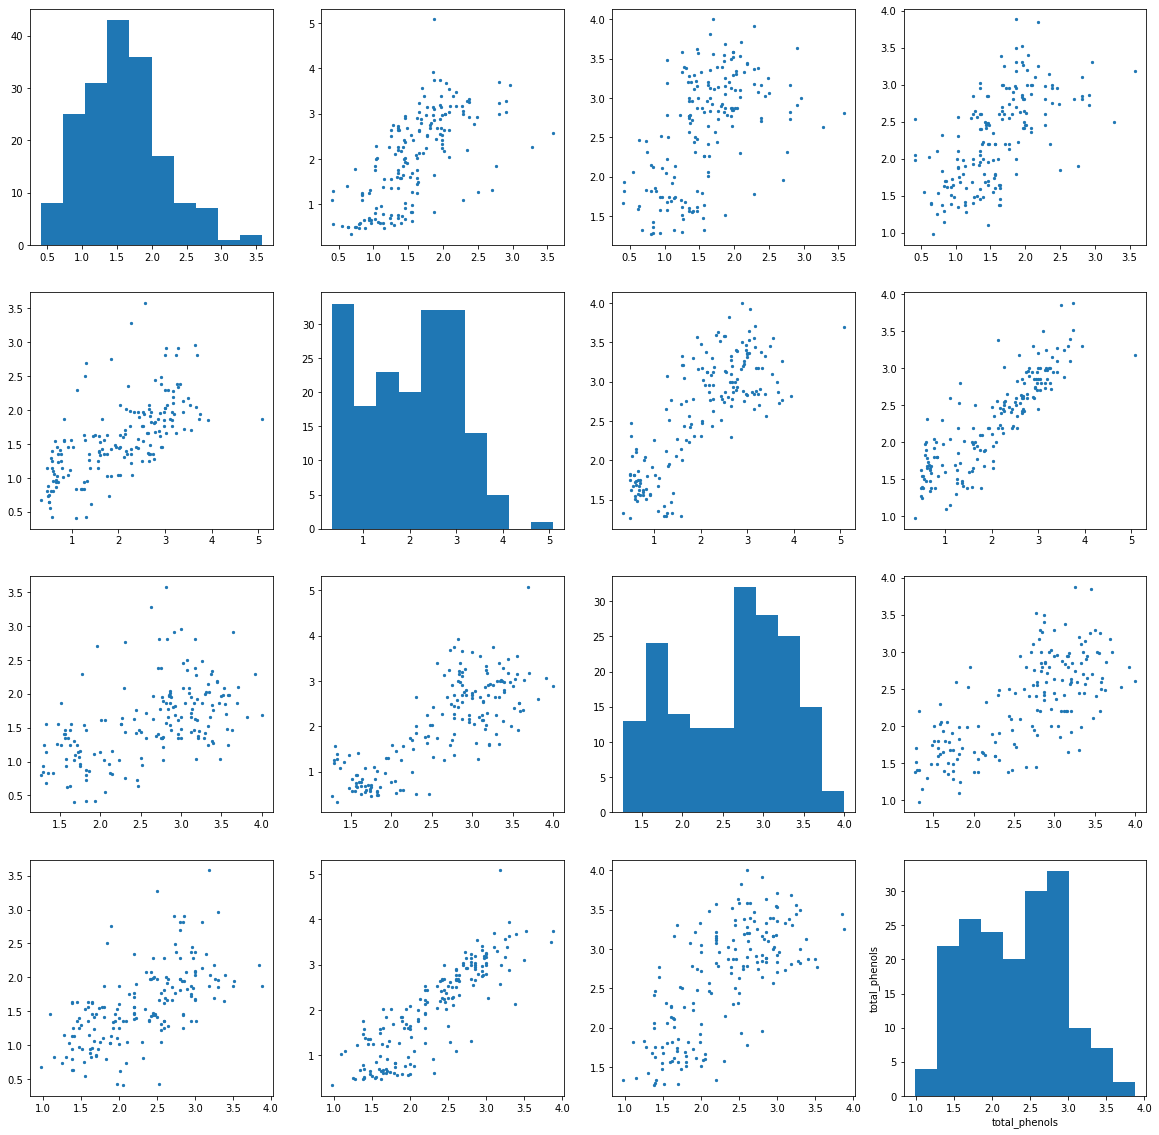

In [221]:
# plot the top features graphs
features = list(newData.columns)
figure, axs = plt.subplots(4,4, figsize = (20,20))

for i, attribute_1 in enumerate(features):
    for j,attribute_2 in enumerate(features):
        if i == j:
            axs[i,j].hist(newData[attribute_1])
            plt.xlabel(attribute_1)
            plt.ylabel(attribute_2)
        else:
            axs[i,j].scatter(newData[attribute_1], newData[attribute_2], 20, marker=".", alpha=1)
            plt.xlabel(attribute_1)
            plt.ylabel(attribute_2)
plt.show()


In [26]:
#get top right triangle indices
indices = []

for i in range(1, len(newData.columns)):
    for j in range(0, i):
        indices.append((j, i))

In [27]:
#save pairs of features
feats = []
for i in range(len(indices)):
    feats.append((features[indices[i][0]], features[indices[i][1]]))

In [269]:
feats.sort()
features

['proanthocyanins',
 'flavanoids',
 'od280/od315_of_diluted_wines',
 'total_phenols']

In [212]:
from sklearn.cluster import KMeans
from scipy import linalg
from numpy import matlib
print(len(feats))

6


In [357]:
probilities = [[0]*3 for i in range(178)]
k = 3
prediction = pd.DataFrame()
for feature in feats:
    ft1 = feature[0]
    ft2 = feature[1]
    #ft1 = 'flavanoids'
    #ft2 = 'od280/od315_of_diluted_wines'
    
    feature1 = np.array(newData[ft1])
    feature2 = np.array(newData[ft2])
    
    datapoints = np.column_stack((feature1, feature2))
    data = pd.DataFrame(datapoints)
    covMatrix = data.corr()
    
    means = getMus(datapoints, k=3)
    means = means[means[:, 0].argsort()]
            
    nearest_mus = find_nearest_mu(datapoints, means)
    
    
    
    for n in range(k):
        x = np.array([])
        y = np.array([])
        for index in range(len(nearest_mus)):
            if nearest_mus[index] == n:
                
                x = np.append(x, feature1[index])
                y = np.append(y, feature2[index])
                
        newDF = pd.DataFrame()
        newDF[ft1] = x
        newDF[ft2] = y
        covMatrix = newDF.corr()
        mu_k = means[n]
        const = 1 / (2*np.pi*np.sqrt(np.linalg.det(covMatrix)))
        for idx in range(data.shape[0]):
            x = [datapoints[idx][0] - mu_k[0]]
            y = [datapoints[idx][1] - mu_k[1]]
            
            ptSub = np.array([x,y])
            ptSubT = -ptSub.T
            covInv = np.linalg.inv(covMatrix)
            exp = np.matmul(np.matmul(ptSubT, covInv), ptSub) / 2
            exponent = np.exp(exp[0][0])
            prob = constant*exponent
            probabilities[idx][n] = prob
    preds = [0]*len(probabilities)
    for i in range(len(probabilities)):
        Max = max(probabilities[i])
        preds[i] = probabilities[i].index(Max)
    prediction[ft1+ft2] = preds
prediction.head()

,flavanoidsod280/od315_of_diluted_wines,flavanoidstotal_phenols,od280/od315_of_diluted_winestotal_phenols,proanthocyaninsflavanoids,proanthocyaninsod280/od315_of_diluted_wines,proanthocyaninstotal_phenols
0,2,2,2,2,2,2
1,2,2,2,1,1,1
2,2,2,2,2,2,2
3,2,2,2,2,2,2
4,2,2,2,2,1,1


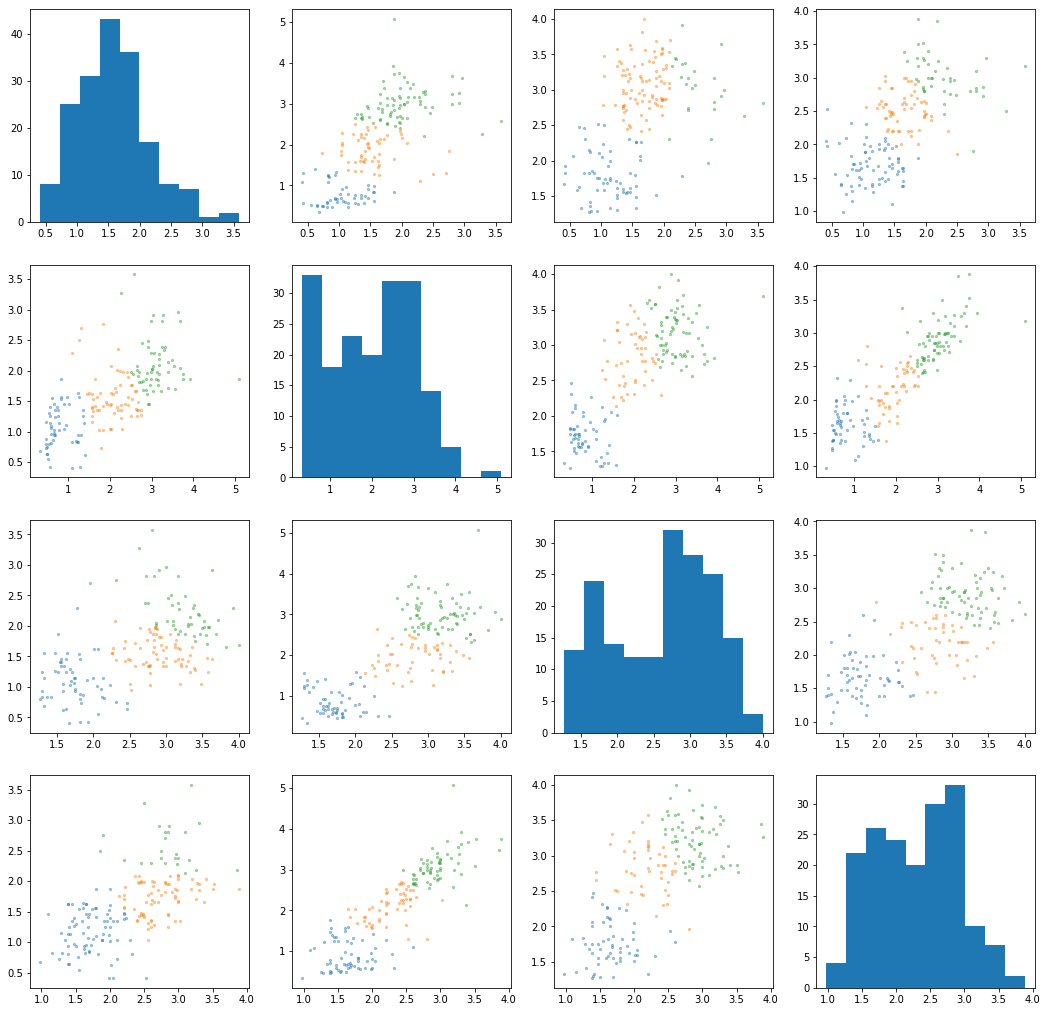

In [355]:
#print(datapoints)
k = 3

def initialize_mus(datapoints, k):
    mus = datapoints.copy()
    np.random.shuffle(mus)
    mus = mus[:k]
    return mus

def find_nearest_mu(datapoints, mus):
    distances = []
    for point in datapoints:
        mu_dist = []
        for k in range(len(mus)):
            dist = np.linalg.norm(point-mus[k])
            mu_dist = np.append(mu_dist, dist)
        distances = np.append(distances, np.argmin(mu_dist))
    return distances

def change_mus(datapoints, distances):
    new_mus = np.zeros((k, 2))
    counts = [0]*k
    for i in range(len(datapoints)):
        nearest_mu = int(distances[i])
        new_mus[nearest_mu] = np.add(new_mus[nearest_mu], datapoints[i])
        counts[nearest_mu] += 1
    counts = np.array(counts)
    counts = np.matlib.repmat(counts, 2, 1)
    new_mus = np.divide(new_mus, counts.T)
    return new_mus

# K-means algorithm
def getMus(datapoints, k):
    mus = initialize_mus(datapoints, k)
    #print(mus)
    epochs = 30
    for _ in range(epochs):
        distances = find_nearest_mu(datapoints, mus)
        mus = change_mus(datapoints, distances)
        
    return mus[mus[:, 0].argsort()]
    
figure, axs = plt.subplots(4,4, figsize = (18,18))

for i in range(4):
    for j in range(4):
        if i != j:
            ft1Name = newData.columns[i]
            ft2Name = newData.columns[j]
            
            feature1 = np.array(newData[ft1Name])
            feature2 = np.array(newData[ft2Name])
            datapoints = np.column_stack((feature1,feature2))
            k = 3
            
            mus = getMus(datapoints, k)
            
            nearest_mus = find_nearest_mu(datapoints, mus)
                
                
            for k in range(k):
                x = np.array([])
                y = np.array([])
                for index in range(len(nearest_mus)):
                    if nearest_mus[index] == k:
                        x = np.append(x, feature1[index])
                        y = np.append(y, feature2[index])
                axs[i,j].scatter(x, y, 20, marker=".", alpha=0.4)
                
        if i == j:
            axs[i,j].hist(feature1)
plt.show()

In [393]:
from sklearn.mixture import GaussianMixture
feats

[('flavanoids', 'od280/od315_of_diluted_wines'),
 ('flavanoids', 'total_phenols'),
 ('od280/od315_of_diluted_wines', 'total_phenols'),
 ('proanthocyanins', 'flavanoids'),
 ('proanthocyanins', 'od280/od315_of_diluted_wines'),
 ('proanthocyanins', 'total_phenols')]

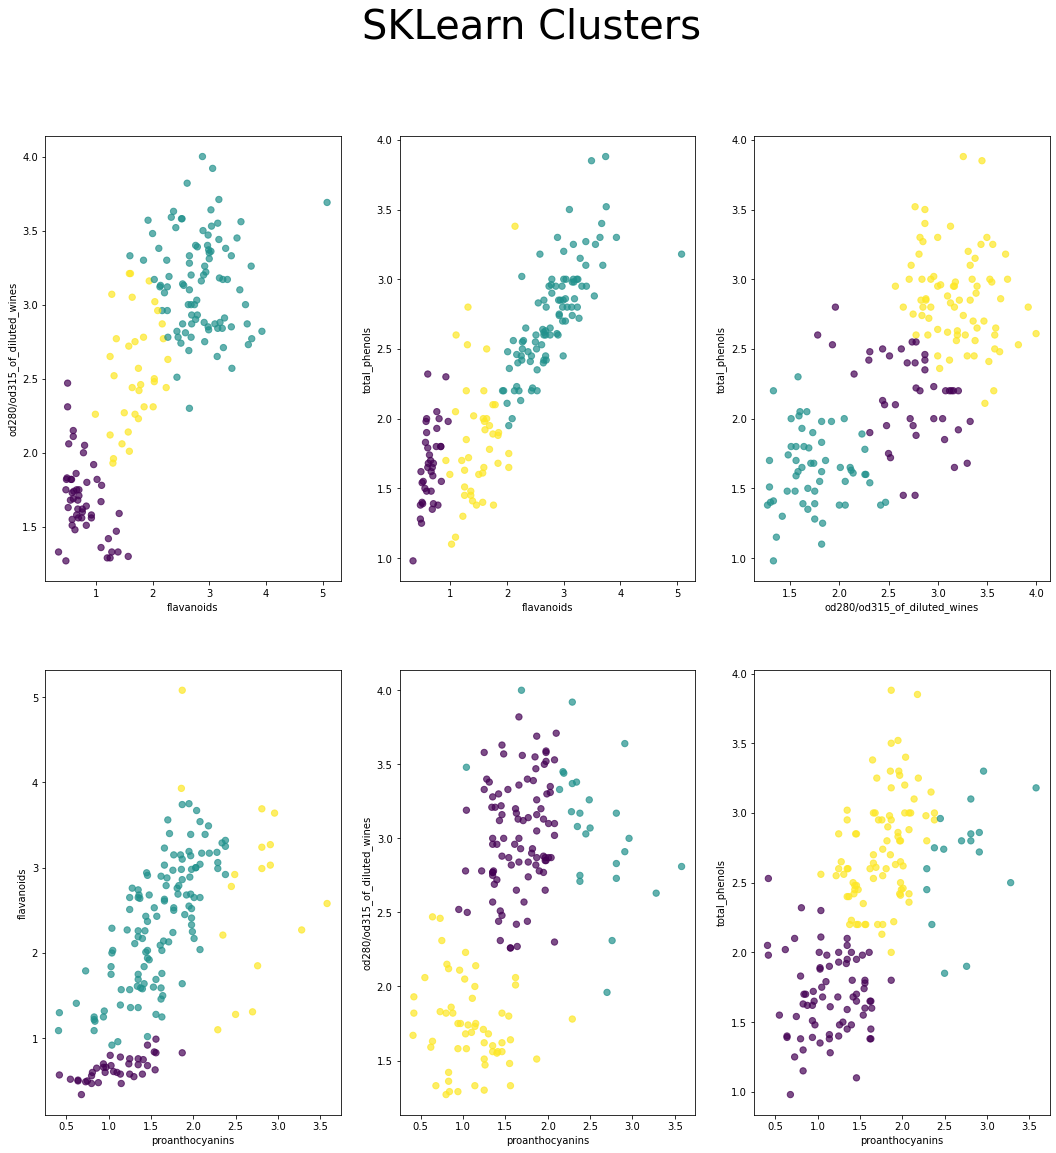

In [412]:
fig, axs = plt.subplots(2, 3, figsize = (18,18))
fig.suptitle('SKLearn Clusters', fontsize=40)
for i in range(len(feats)):
    ft1 = feats[i][0]
    ft2 = feats[i][1]
    X = newData[[ft1, ft2]]
    gmm = GaussianMixture(n_components=3).fit(X)
    labels = gmm.predict(X)
    if i == 0:
        axs[0, 0].scatter(X[ft1], X[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[0, 0].set(xlabel=ft1, ylabel=ft2)
    elif i == 1:
        axs[0, 1].scatter(X[ft1], X[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[0, 1].set(xlabel=ft1, ylabel=ft2)

    elif i == 2:
        axs[0, 2].scatter(X[ft1], X[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[0, 2].set(xlabel=ft1, ylabel=ft2)

    elif i == 3:
        axs[1, 0].scatter(X[ft1], X[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[1, 0].set(xlabel=ft1, ylabel=ft2)

    elif i == 4:
        axs[1, 1].scatter(X[ft1], X[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[1, 1].set(xlabel=ft1, ylabel=ft2)

    elif i == 5:
        axs[1, 2].scatter(X[ft1], X[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[1, 2].set(xlabel=ft1, ylabel=ft2)



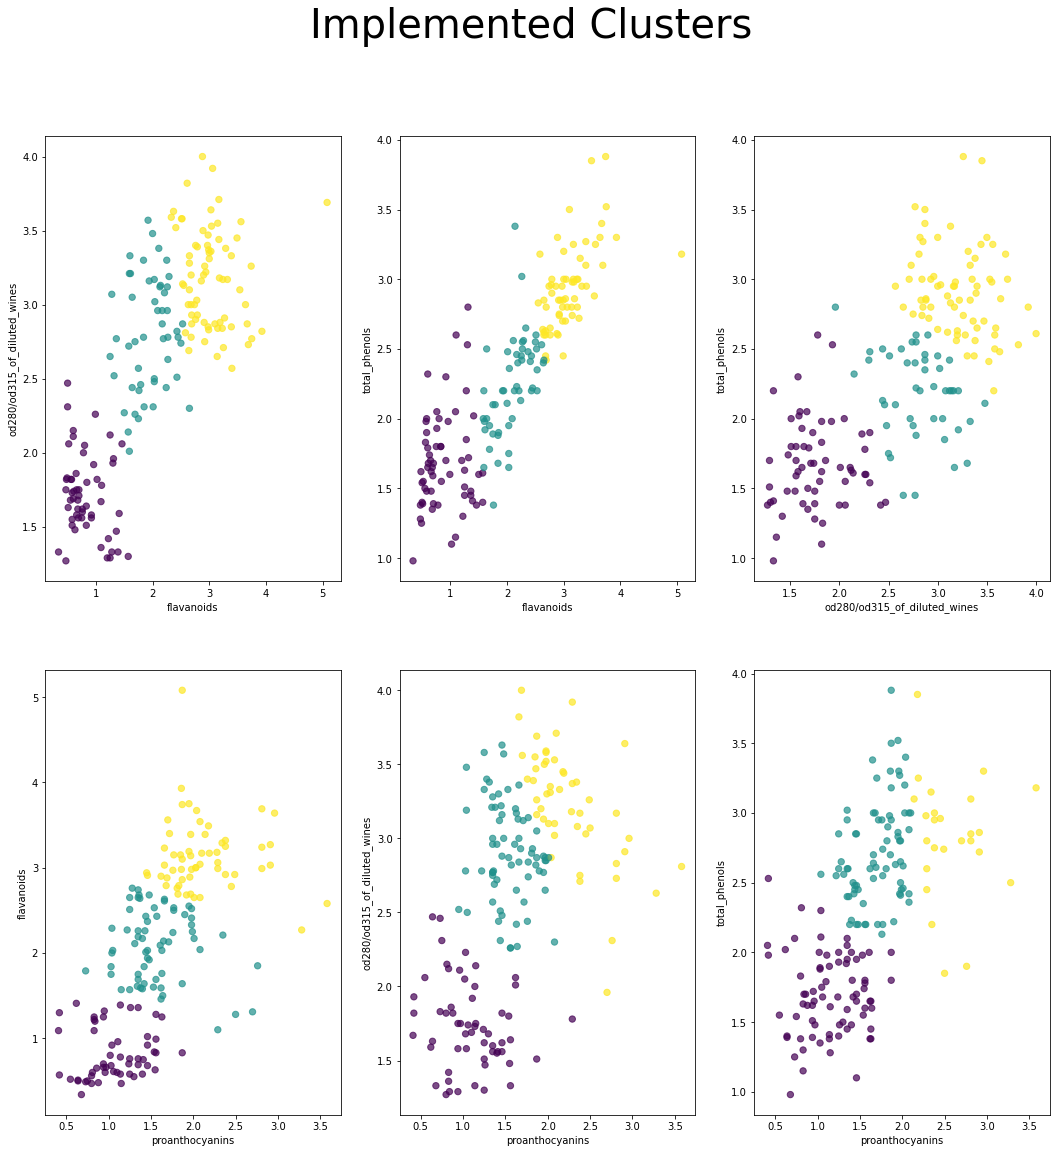

In [415]:
fig, axs = plt.subplots(2, 3, figsize = (18,18))
fig.suptitle('Implemented Clusters', fontsize=40)
for i in range(len(feats)):
    ft1 = feats[i][0]
    ft2 = feats[i][1]
    labels = np.array(prediction[ft1+ft2])
    if i == 0:
        axs[0, 0].scatter(newData[ft1], newData[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[0, 0].set(xlabel=ft1, ylabel=ft2)
    elif i == 1:
        axs[0, 1].scatter(newData[ft1], newData[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[0, 1].set(xlabel=ft1, ylabel=ft2)

    elif i == 2:
        axs[0, 2].scatter(newData[ft1], newData[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[0, 2].set(xlabel=ft1, ylabel=ft2)

    elif i == 3:
        axs[1, 0].scatter(newData[ft1], newData[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[1, 0].set(xlabel=ft1, ylabel=ft2)

    elif i == 4:
        axs[1, 1].scatter(newData[ft1], newData[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[1, 1].set(xlabel=ft1, ylabel=ft2)

    elif i == 5:
        axs[1, 2].scatter(newData[ft1], newData[ft2], c=labels, s=40, cmap='viridis', alpha=0.7)
        axs[1, 2].set(xlabel=ft1, ylabel=ft2)